# Relatório de Modelagem e Simulação - Grupo Enzo

**Membros**:
- Ísis Ardisson Logullo
- João Pedro Lukasavicus Silva
- Leonardo Martinez Ikeda
- Matheus Conceição
- Vitor Barbosa Sério

## Introdução

Esse trabalho consiste em um estudo de Movimento Retilíneo Uniforme(MRU) e de Movimento Retilíneo Uniformemente Variado(MRUV). Para tanto, foi medido o tempo em que pessoas diversas percorreram distâncias pré-determinadas em ambos os regimes precitados (MRU e MRUV). Num espaço de 30m de comprimento, o chão foi marcado com distâncias de 0,5m. Essa distância representa o tamanho da passada de todas as pessoas que realizariam o experimento. Nos pontos 10m, 20m e 30m haviam 2 cronômetros distintos marcando o tempo em que a pessoa passava por aquela distância. Assim, na versão MRU cada participante andou num ritmo constante próprio sobre as marcações. Na versão MRUV foi incrementado o uso de metrônomo, para ir acelerando o ritmo, cada passada era 1 bpm a mais. Junto disso todos faziam a travessia com um acelerômetro acionado. Apenas uma medida de cada pessoa teve uma variante de pontos de marcação, sendo apenas 1 cronômetro nas posições 5m, 10m, 15m, 20m, 25m e 30m, em ambos experimentos. Após a coleta desses dados, foram determinados valores de velocidade e aceleração que se adaptassem aos pontos experimentais e satisfizessem as seguintes funções:

$\text{MRU: }s(t) = vt + s_0$

$\text{MRUV: }\begin{cases} s(t) = \cfrac{a}{2}t^2 + v_0t + s_0 \\
                            v(t) = at + v_0 \end{cases}$
                            
Onde $s(t)$ é a posição no espaço em um tempo $t$, $v(t)$ é a velocidade de uma pessoa no tempo $t$, $v$ é uma velocidade constante, $a$ é uma aceleração constante, $v_0$ é a velocidade inicial e, finalmente, $s_0$ é a posição inicial. É importante definir que:

$v = \cfrac{ds}{dt}$

e

$a = \cfrac{dv}{dt}$

Portanto, como as informações que coletadas são as de $s(t)$ e $t$, podemos determinar $v$ e $a$ pelas médias dos pontos experimentais:

$v = \cfrac{1}{n}\displaystyle \sum_{i = 0}^{n} \cfrac{s(t_i) - s_0}{t_i}$, para MRU

e

$a = \cfrac{1}{n}\displaystyle \sum_{i = 0}^{n} 2\cfrac{s(t_i) - s_0 - v_0 t_i}{t_i^2}$, para MRUV

Abaixo um link para o vídeo do experimento realizado.
http://www.youtube.com/watch?v=NG1ZBwy8VBw

Agora, para iniciar o programa, vamos primeiro importar as bibliotecas que serão utilizadas.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import math

## Método
Os dados coletados foram armazenados em uma planilha, em formato csv, contendo as medidas dos cronômetros do experimento, a distância percorrida, qual pessoa realizou a travessia (P1, P2 ou P3), qual foi a travessia (T1 ou T2), se os cronometros estavam deslocados ou não e, claro, se o movimento era MRU ou MRUV.

Abaixo temos o código onde definimos funções auxiliares para executarem os cálculos e armazenar os resultados e também para plotar os gráficos necessários.

In [2]:
def arruma_tempos(raw_data):
    ''' DataFrame -> DataFrame
    Calcula a média dos tempos nas posições em que havia mais de um cronômetro medindo.
    '''
    data = raw_data[raw_data['Deslocado'] == False].copy()
    
    for row in data.index.values:
        try:
            t1 = data.at[row, 'Tempo']
            t2 = data.at[row + 1, 'Tempo']
            data.at[row, 'Tempo'] = ((t1 + t2)/2)
            data = data.drop(row + 1)
            pass
        except:
            continue
    
    data = pd.concat([data, raw_data[raw_data['Deslocado'] == True]])
    
    data = data.reset_index(drop = True)
            
    return data

def calc_vel(data):
    ''' DataFrame -> DataFrame
    Calcula a velocidade média a partir do ponto inicial até o momento do tempo coletado,
    para cada ponto experimental.
    '''
    data['Velocidade'] = 0.0

    index = data.index.values

    for i in index:
        data.at[i, 'Velocidade'] = data.at[i, 'Distancia'] / data.at[i, 'Tempo']

    return data

def calc_res(data):
    ''' DataFrame -> DataFrame
    Calcula a velocidade média para cada pessoa, em MRU, e, em MRUV calcula a aceleração
    e a velocidade inicial.
    '''
    def calc_vel_mru(data):
        ''' DataFrame -> vetor
        Calcula a velocidade média para cada pessoa, em MRU.
        '''
        data = data[data['Tipo'] == 'MRU'].copy()
        
        data['v'] = 0.0
        
        pessoa = data['Pessoa'].unique()
    
        vel = []
        for p in pessoa:
            
            df = data[data['Pessoa'] == p]
            
            vm = df['Velocidade'].mean()
                
            vel.append(vm)
            
        return vel
    
    def calc_ac_mruv(data, res):
        ''' DataFrame -> DataFrame
        Calcula a aceleração média e a velocidade inicial para cada pessoa, em MRUV.
        '''
        data = data[data['Tipo'] == 'MRUV'].copy()
        
        data['a'] = 0.0
        res['v0'] = [0.55, 0.6, 0.7] # velocidades iniciais atribuídas arbitrariamente
        
        
        pessoa = data['Pessoa'].unique()
    
        for p in pessoa:
            
            P = data['Pessoa'] == p
            
            index = data[P].index.values
                
            v0 = res.at[p, 'v0']
            
            for i in index:
                
                si = data.at[i, 'Distancia']
                ti = data.at[i, 'Tempo']
                data.at[i, 'a'] = 2 * (si - v0 * ti) / (ti ** 2)
                
            res.at[p, 'am'] = data.loc[index, 'a'].mean()
            
        return res
    
    res = pd.DataFrame(index = data['Pessoa'].unique(), columns = ['vm', 'am', 'v0'])
    
    res['vm'] = calc_vel_mru(data)
    res = calc_ac_mruv(data, res)
    
    res.loc['Geral'] = res.mean()
    
    return res
    
    
###############################################################################
# Funções para plotar os gráficos

def plot(data, res, m = 0, p = 1, v = 0, erro = True, show = False):
    ''' DataFrame, DataFrame, int, int, int, bool, bool -> void
    Recebe todos os dados e imprime o gráficos, de acordo com o regime dado (m), a pessoa
    alvo (p), se é um gráficos de velocidade (v), se é um gráficos de erro (erro) e se é
    para já exibir o gráfico ao final (show)
    '''
    
    def plot_data(x, y, a, b = 0, parab = False, show = True):
        ''' Vetor, vetor, int, int, bool, bool -> void
        Recebe os valores do eixo x (x) e do eixo y (y) e imprime o gráficos, de acordo com
        os coeficientes passados (a e b), se é um gráfico quadrático (parab) e se é para exibir
        o gráfico.
        '''
    
        def plot_line(x, y, a, b, show = True):
            ''' Vetor, vetor, int, int, bool -> void
            Recebe os valores do eixo x (x) e do eixo y (y) e imprime um gráfico linear, de 
            acordo com os coeficientes passados (a e b) e se é para exibir o gráfico.
            '''
            
            xmax = x.max() + 5
            ymax = a * xmax + b
            
            plt.scatter(x, y)
            plt.plot([0, xmax], [b, ymax], '--')
            if show: plt.show()
            
            return
    
        def plot_parab(x, y, a, b, show = True):
            ''' Vetor, vetor, int, int, bool -> void
            Recebe os valores do eixo x (x) e do eixo y (y) e imprime um gráfico quadrático, de 
            acordo com os coeficientes passados (a e b) e se é para exibir o gráfico.
            '''
            
            xmax = x.max() + 5
            
            tx = np.linspace(0, xmax, 1000)
            ty = (a * (tx ** 2)) / 2 + b * tx
            
            plt.scatter(x, y)
            plt.plot(tx, ty, '--')
            if show: plt.show()
            
            return   
    
        if parab: plot_parab(x, y, a, b, show)
        else: plot_line(x, y, a, b, show)
        
        return
    
    def plot_erro(x, y, a, b, s = ' (m)', parab = False, show = True):
        ''' Vetor, vetor, int, int, bool, bool -> void
        Recebe os valores do eixo x (x) e do eixo y (y) e imprime um gráfico de erros, de acordo com
        os coeficientes passados (a e b), se é um gráfico quadrático (parab) e se é para exibir
        o gráfico.
        '''
        
        xmax = x.max() + 5
        
        if parab:
            e = y - ((a * (x ** 2)) / 2 + (b * x))
        else:
            e = y - (a * x + b)
        
        plt.ylabel('Erro' + s)
        plt.scatter(x, e)
        plt.plot([0, xmax], [0, 0], '--')
        if show: plt.show()
        
        return
    
    # Filtrando os dados passados
    mov = ['MRU', 'MRUV'][m]
    pes = ['Geral', 'P1', 'P2', 'P3'][p]
    
    P = data['Pessoa'] == pes if p > 0 else True
    M = data['Tipo'] == mov
    
    df = data[M & P].copy()
    df = df.reset_index(drop = True)
    
    # Determinando x e y
    x = 'Tempo'
    plt.xlabel(x + ' (s)')
    x = df[x] / 2 if v else df[x]
    
    y = 'Velocidade' if v else 'Distancia'
    s = ' (m/s)' if v else ' (m)'
    plt.ylabel(y + s) if v else plt.ylabel(y + s)
    y = df[y]
    
    # Determinando a, b e parab
    a = res.at[pes, 'am'] if m else res.at[pes, 'vm']
    b = res.at[pes, 'v0'] if m else 0
    
    parab = True if m and not v else False
    
    # Imprimindo o gráfico
    if erro:
        plot_erro(x, y, a, b, s, parab, show)
        
    else:
        plt.title('Pessoa ' + str(p))
        plot_data(x, y, a, b, parab, show)
        
    return

raw_data = pd.read_csv("tempos.csv")

# Arrumando os dados e calculando os resultados
data = arruma_tempos(raw_data)
data = calc_vel(data)
res = calc_res(data)

É importante notar que, para todos os experimentos, $s_0 = 0$. Inicialmente foi considerado que $v_0 = 0$ também, mas, ao plotar os gráficos, notou-se que isso não era válido para MRUV. Faz sentido, pois, ao iniciar a caminhada, ocorre uma aceleração inicial mais alta que no restante do percurso (pois a pessoa sai do repouso em um espaço de tempo muito curto). Como simular isso seria mais complexo que o modelo proposto inicialmente, esse fenômeno foi simplificado para simplesmente considerar que existe um $v_0 > 0$ nos experimentos de MRUV.

Os valores para esses $v_0$ foi estimado arbitrariamente, baseado na disposição dos pontos experimentais no gráfico.

## Dados

Primeiro, vamos mostrar os resultados para MRU.

In [3]:
display(res.loc[:, 'vm'])

P1       0.644593
P2       0.909135
P3       0.800378
Geral    0.784702
Name: vm, dtype: float64

Portanto, os modelos para MRU ficam como:

$s_{Pessoa 1}(t) = 0.645t$

$s_{Pessoa 2}(t) = 0.909t$

$s_{Pessoa 3}(t) = 0.800t$

$s_{Geral}(t) = 0.785t$

Plotando os gráficos para representar esses resultados, juntamente com o gráfico dos erros

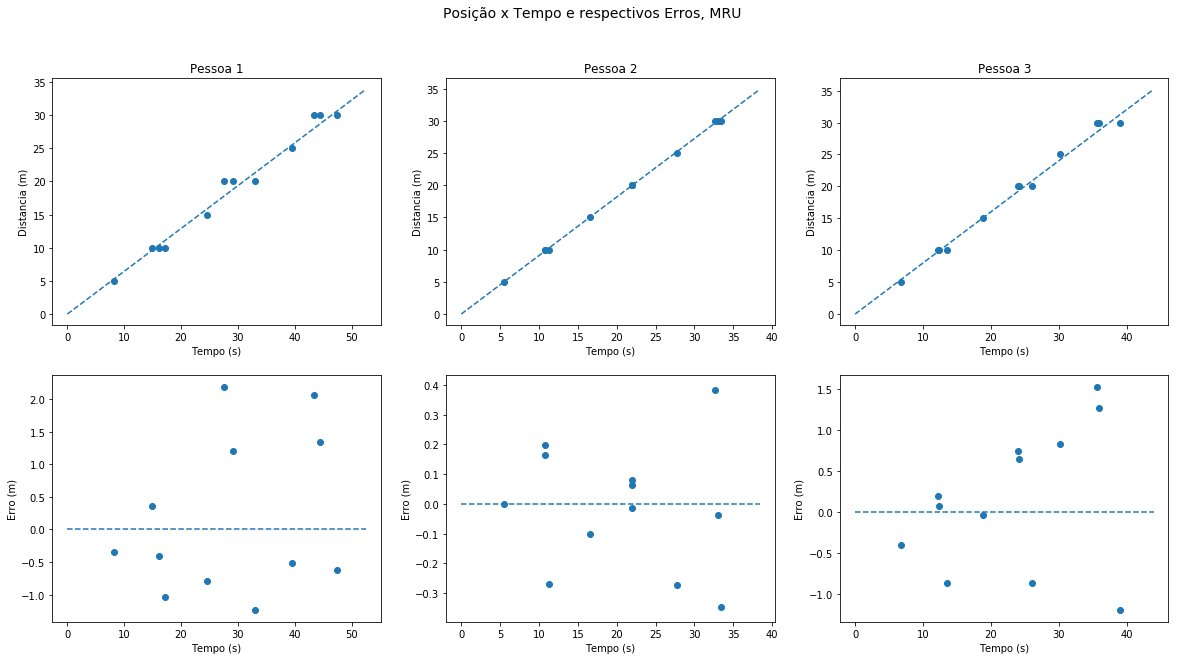

In [4]:
# Plotando todos os gráficos de espaço por tempo MRU

plt.figure(figsize = (20, 10), facecolor = '#FFFFFF')
plt.suptitle('Posição x Tempo e respectivos Erros, MRU', fontsize = 14)

i = 1
m = 0
for erro in [False, True]:
    for p in [1, 2, 3]:
        
        plt.subplot(2, 3, i)
        plot(data, res, m, p, 0, erro)
        i += 1

plt.show()

Observando os gráficos acima, percebemos que os modelos calculados se encaixaram bem aos pontos experimentais obtidos. Os gráficos dos erros nos mostram que os maiores erros estão presentes em $s_{Pessoa 1}(t)$, mas o erro não ultrapassa muito de 2m. Além disso, dá pra notar que o gráfico da Pessoa 2 possui erros bem pequenos e todos os pontos ficaram próximos ao modelo calculado. (Será um robô!?)

Agora vamos fazer o mesmo para MRUV, começando pelos gráficos de posição por tempo.

In [5]:
display(res.loc[:, ['am', 'v0']])

,am,v0
P1,0.00540077,0.550000
P2,0.00837667,0.600000
P3,0.0022116,0.700000
Geral,0.00532968,0.616667


Portanto, os modelos espaciais para MRU ficam como:

$s_{Pessoa 1}(t) = 0.003t^2 + 0.550t$

$s_{Pessoa 2}(t) = 0.004t^2 + 0.600t$

$s_{Pessoa 3}(t) = 0.001t^2 + 0.700t$

$s_{Geral}(t) = 0.003t^2 + 0.617t$

Novamente, vamos plotar os gráficos para representar esses resultados, juntamente com o gráfico dos erros

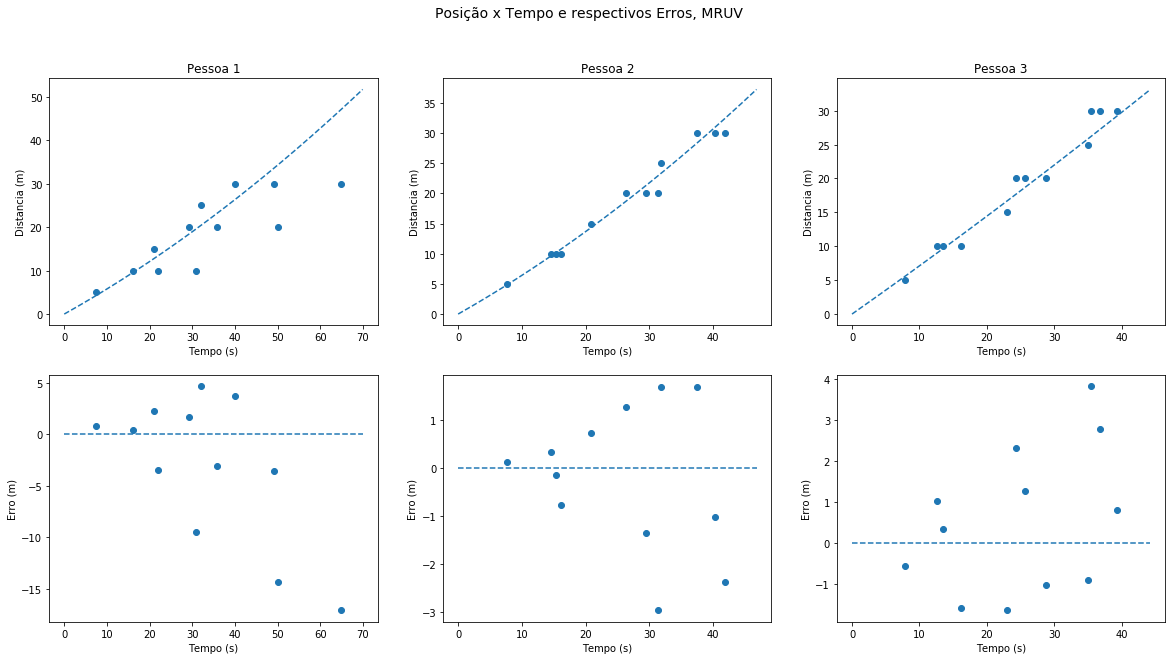

In [6]:
plt.figure(figsize = (20, 10), facecolor = '#FFFFFF')
plt.suptitle('Posição x Tempo e respectivos Erros, MRUV', fontsize = 14)

i = 1
m = 1
for erro in [False, True]:
    for p in [1, 2, 3]:
        
        plt.subplot(2, 3, i)
        plot(data, res, m, p, 0, erro)
        i += 1

plt.show()

Tanto pelos valores numéricos quanto pela aparência dos gráficos, nota-se que esses modelos se adequam bem menos aos dados experimentis, principalmente no caso da Pessoa 1, onde o erro ultrapassa 15m. Por outro lado, a alta dispersão dos pontos no gráfico da Pessoa 1 também indica um erro no coleta de dados. Provavelmente não foi utiliada a mesma aceleração constante em todos os experimentos. Além disso, foram atribuídos valores arbitrários para os $v_0$, o que também tende a aumentar o erro observado.

Agora, vamos finalmente avaliar a velocidade durante o MRUV (a tabela dos valores para $a$ e $v_0$ é a mesma de $s(t)$, então

$s_{Pessoa 1}(t) = 0.005t + 0.550$

$s_{Pessoa 2}(t) = 0.008t + 0.600$

$s_{Pessoa 3}(t) = 0.002t + 0.700$

$s_{Geral}(t) = 0.005t + 0.617$

Plotando os gráficos:

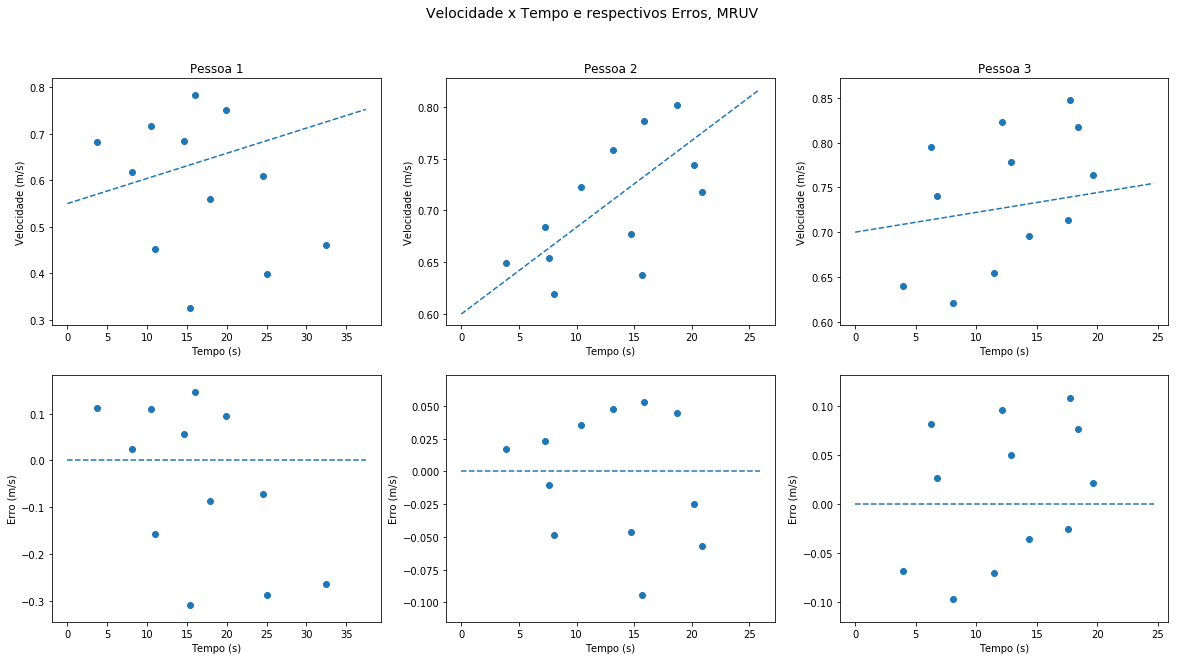

In [7]:
plt.figure(figsize = (20, 10), facecolor = '#FFFFFF')
plt.suptitle('Velocidade x Tempo e respectivos Erros, MRUV', fontsize = 14)

i = 1
m = 1
for erro in [False, True]:
    for p in [1, 2, 3]:
        
        plt.subplot(2, 3, i)
        plot(data, res, m, p, 1, erro)
        i += 1

plt.show()

Agora, para as velocidades, o modelo parece ser bastante adequando, com o maior erro sendo um pouco maior que 0.3m/s apenas no gráfico da Pessoa 1. Os outros gráficos apresentam erros de no máximo 0.1m/s (aproximadamente). Ainda assim, nota-se que a distribuição dos erros em torno do 0 é assimétrica, indicando que o modelo ainda poderia ser mais bem adequado, principalmente para o caso da Pessoa 1.

## Interpretação

Ao analisar os dados concluímos a dificuldade de aferir dados de medida de MRUV com o experimento simples que fizemos. Houve maiores erros do que o MRU, não deixando de ser próximo do esperado, mas com erros bem visíveis. Mesmo tentando seguir um ritmo uniformemente acelerado do metrônomo a execução não foi tão fiel. Ainda assim, o modelo se mostrou bastante preciso no caso da veocidade por tempo. 

Agora, no MRU obtivemos maior êxito, se compararmos o resultado com o de posição por tempo do MRUV. Em alguns casos o modelo chegou a ser quase isentos de erro, mas na maioria bem próximo do esperado. As pessoas que tem uma constância maior de ritmo conseguiram passar isso pros dados do experimento. Fisicamente é muito mais facil um movimento MRU do que um MRUV que envolve aceleração. Isso ficou bem claro na coleta de dados analisados.

Para um trabalho futuro pode ser interessante tentar elaborar um método melhor para garantir uma aceleração constante, prestar mais atenção quanto a tentar manter a aceleração e a velocidade constantes (quando conveniente) através de todos os experimentos e também tomar um maior cuidado quanto à velocidade inicial, no MRUV.

## Crítica

O experimento aborda MRU e MRUV na cinemática. Ao analisarmos computacionalmente esses dados aprendemos, através de novas ferramentas, uma análise mais dinâmica e rápida. Os gŕaficos gerados deixam as informações de movimento mais visível, graças a associação de movimento físico. Percebemos que a prática não é igual a teoria, aparecendo muitos erros (mais ou menos dependendo do experimento) nos distanciando do resultado esperado. Através da ideia e realização do experimento notamos as falhas na concepção de aferimento de dados, nos levando a melhores ideias que possam aprimorar essa coleta e talvez diminuir os erros medidos. No quesito técnico, aprendemos a usar a biblioteca do Anaconda para plotar gráficos. Tivemos dificuldades em conseguir analisar os dados do acelerômetro para comparar com os coletados por cronômetro falhando em executar essa parte.

## Registro

- Realização do experimento, andando e gravando com cronômetros - Ísis, João, Matheus
- Anotação dos dados - Vitor
- Gravação do vídeo - Leonardo
- Edição do video e upload no youtube - Leonardo
- Criação do código de plotagem e analise dos dados e dos erros - Vitor, Matheus
- Criação dos gráficos - Vitor, Matheus
- Estruturação e redação do relatório - Ísis, Vitor

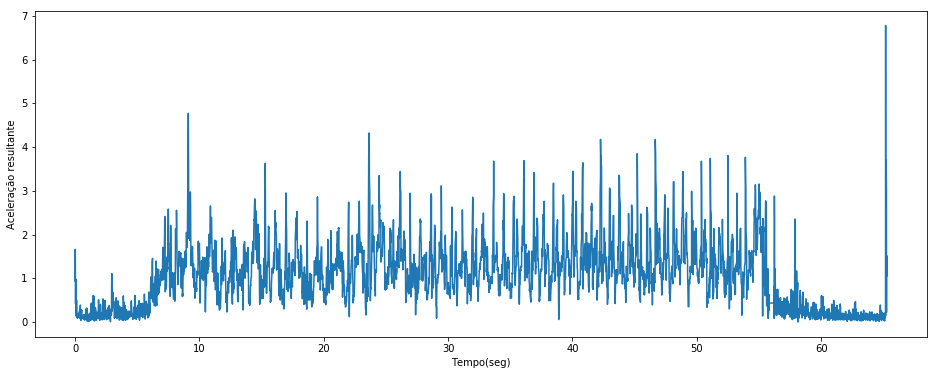

0         0.004
1         0.008
2         0.009
3         0.013
4         0.019
5         0.022
6         0.028
7         0.033
8         0.037
9         0.043
10        0.046
11        0.052
12        0.058
13        0.062
14        0.081
15        0.081
16        0.082
17        0.082
18        0.086
19        0.090
20        0.096
21        0.101
22        0.106
23        0.110
24        0.116
25        0.120
26        0.126
27        0.130
28        0.137
29        0.140
          ...  
13296    65.163
13297    65.163
13298    65.163
13299    65.164
13300    65.165
13301    65.165
13302    65.169
13303    65.174
13304    65.179
13305    65.185
13306    65.189
13307    65.194
13308    65.200
13309    65.204
13310    65.208
13311    65.218
13312    65.219
13313    65.224
13314    65.230
13315    65.256
13316    65.257
13317    65.257
13318    65.258
13319    65.258
13320    65.258
13321    65.263
13322    65.268
13323    65.272
13324    65.277
13325    65.282
Name: time, Length: 1332

'\nv = {}\nfor n in range(1, 4):\n    print (n)\n    p = {}\n    data = pd.read_csv("ac00" + str(n) + "1.csv")\n    print(data)\n    p[\'MRU normal\' + str(n)] = {}\n    p[\'MRU normal\' + str(n)][\'time\'] = data[\'time\']\n    p[\'MRU normal\' + str(n)][\'aT\'] = data[\'aT\']\n    v[n] = p\n    \nfor n in range(2, 4):\n    ep = v[n]\n    plt.figure(figsize=(16,6))\n    plt.ylabel(\'Aceleração resultante\')\n    plt.xlabel(\'Tempo(seg)\')\n    plt.plot(ep[\'time\'], ep[\'aT\'])\n    plt.show()\nfor n in range(2, 4):\n    ep = v\nplt.figure(figsize=(16,6))\nplt.ylabel(\'Aceleração resultante\')\nplt.xlabel(\'Tempo(seg)\')\nplt.plot(ep[\'time\'], ep[\'aT\'])\nplt.show()\n'

In [34]:
data = pd.read_csv("ac0011.csv")
plt.figure(figsize=(16,6))
plt.ylabel('Aceleração resultante')
plt.xlabel('Tempo(seg)')
plt.plot(data['time'], data['aT'])
plt.show()
print (data['time'])
print (data['aT'])
'''
v = {}
for n in range(1, 4):
    print (n)
    p = {}
    data = pd.read_csv("ac00" + str(n) + "1.csv")
    print(data)
    p['MRU normal' + str(n)] = {}
    p['MRU normal' + str(n)]['time'] = data['time']
    p['MRU normal' + str(n)]['aT'] = data['aT']
    v[n] = p
    
for n in range(2, 4):
    ep = v[n]
    plt.figure(figsize=(16,6))
    plt.ylabel('Aceleração resultante')
    plt.xlabel('Tempo(seg)')
    plt.plot(ep['time'], ep['aT'])
    plt.show()
for n in range(2, 4):
    ep = v
plt.figure(figsize=(16,6))
plt.ylabel('Aceleração resultante')
plt.xlabel('Tempo(seg)')
plt.plot(ep['time'], ep['aT'])
plt.show()
'''